In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dehazing-erza/kabut1.jpeg
/kaggle/input/plangkabut/plang.jpg
/kaggle/input/bromomotor/bromo-motor-kabut.jpg
/kaggle/input/bromo1/bromo2.jpg
/kaggle/input/bromo-kabut/bromo kabut.jpg
/kaggle/input/hutan3/hutan3.jpg
/kaggle/input/bromo2/bromo1.jpg
/kaggle/input/hutan2/hutan2.jpg


In [2]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def DarkChannel(im,sz):
  r,g,b = cv2.split(im)
  dc = cv2.min(cv2.min(r,g),b)
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
  dark = cv2.erode(dc, kernel)
  return dark

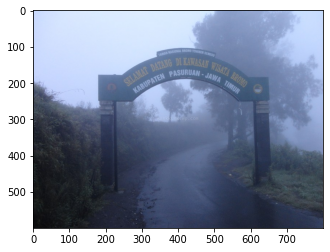

In [4]:
img = cv2.imread("/kaggle/input/plangkabut/plang.jpg",1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

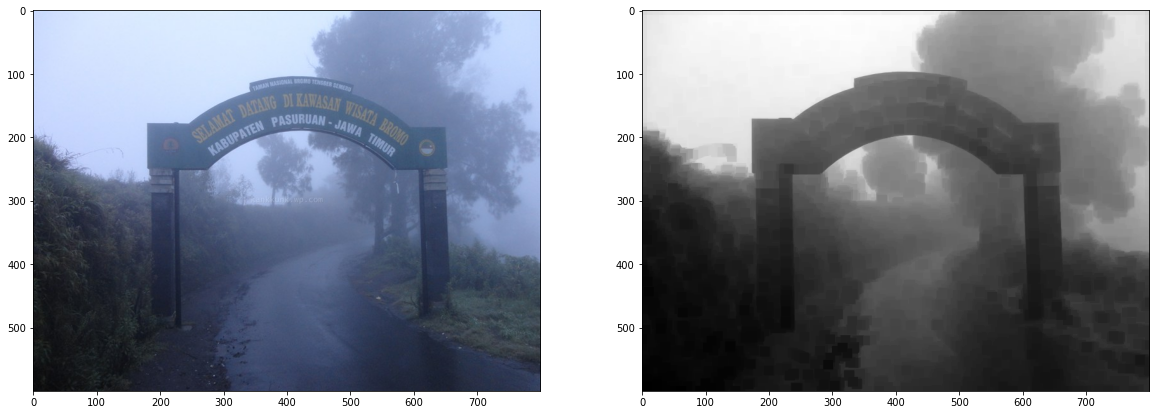

In [5]:
img_out = DarkChannel(img,15)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img,cmap="gray")
plt.subplot(1,2,2)
plt.imshow(img_out,cmap="gray")
plt.show()


In [6]:
def AtmLight(im, dark):
  [h,w] = im.shape[:2]
  imsz = h * w
  numpx = int(max(math.floor(imsz / 1000), 1))
  darkvec = dark.reshape(imsz, 1)
  imvec = im.reshape(imsz, 3)

  indices = darkvec.argsort()
  indices = indices[imsz - numpx::]

  atmsum = np.zeros([1,3])
  for ind in range(1, numpx):
    atmsum = atmsum + imvec[indices[ind]]

  A = atmsum / numpx
  return A

In [7]:
def TransmissionEstimate(im,A,sz):
  omega = 0.95
  im3 = np.empty(im.shape, im.dtype)

  for ind in range(0,3):
    im3[:,:, ind] = im[:,:,ind] / A[0, ind]

  transmission = 1 - omega * DarkChannel(im3, sz)
  return transmission
img = cv2.imread("/kaggle/input/plangkabut/plang.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img.astype('float64') / 255

dark = DarkChannel(img,15)
A = AtmLight(img, dark)
te = TransmissionEstimate(img, A, 15)


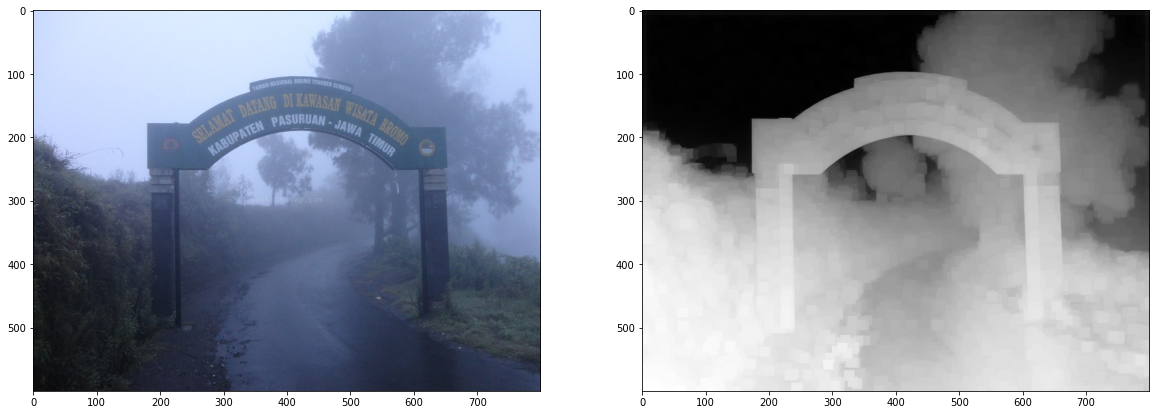

In [8]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img,cmap="gray")
plt.subplot(1,2,2)
plt.imshow(te,cmap="gray")
plt.show()

In [9]:
def Guidedfilter(im,p,r,eps):
    mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
    mean_p = cv2.boxFilter(p,cv2.CV_64F,(r,r));
    mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
    cov_Ip = mean_Ip - mean_I*mean_p;
    
    mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
    var_I = mean_II - mean_I*mean_I;
    
    a = cov_Ip/(var_I + eps);
    b = mean_p - a*mean_I;
    
    mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
    mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));
    
    q = mean_a*im + mean_b;
    return q;

In [10]:
def TransmissionRefine (im, et):
    gray = cv2.cvtColor (im, cv2.COLOR_BGR2GRAY)
    gray = np.float64(gray) / 255
    r = 60 
    eps = 0.0001
    t = Guidedfilter(gray,et,r,eps)
    return t

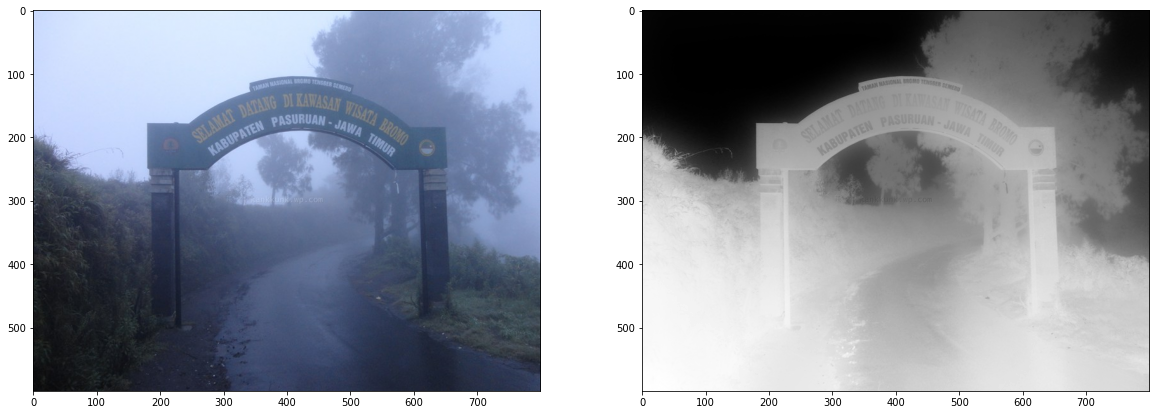

In [11]:
imgOriginal = cv2.imread("/kaggle/input/plangkabut/plang.jpg")
img = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2RGB)
img = img.astype('float64') / 255
dark = DarkChannel(img, 15)
A = AtmLight(img, dark)
te = TransmissionEstimate(img, A, 15)
t_refined = TransmissionRefine(imgOriginal, te)
plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.imshow(img,cmap="gray")
plt.subplot(1,2,2)
plt.imshow(t_refined,cmap="gray")
plt.show()

In [12]:
def Recover(im,t,A,tx=0.1):
  res = np.empty(im.shape, im.dtype)
  t = cv2.max(t, tx)

  for ind in range(0,3):
    res[:,:,ind] = (im[:,:,ind] - A[0,ind]) / t + A[0,ind]
  return res

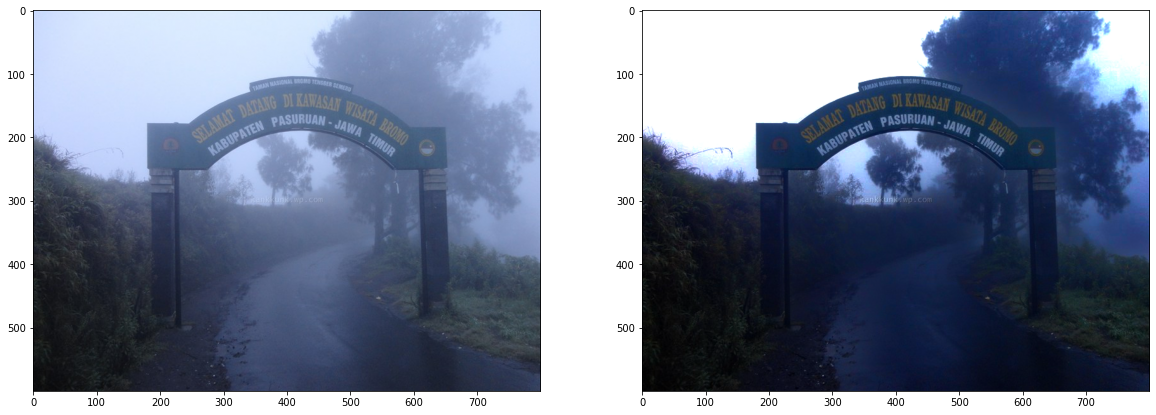

In [13]:
imgOriginal = cv2.imread("/kaggle/input/plangkabut/plang.jpg")
img = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2RGB)
img = img.astype('float64') / 255
dark = DarkChannel(img, 15)
A = AtmLight(img, dark)
te = TransmissionEstimate(img, A, 15)
t_refined = TransmissionRefine(imgOriginal, te)
J = Recover(img, t_refined, A, 0.1)  
plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.imshow(img,cmap="gray")
plt.subplot(1,2,2)
plt.imshow(J,cmap="gray")
plt.show()